YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2024-12-23  254.655716  255.034791  252.840088  254.156919  40858800
2024-12-24  257.578674  257.588630  254.675658  254.875189  23234700
2024-12-26  258.396667  259.474086  257.010028  257.568678  27237100
2024-12-27  254.974930  258.077462  252.451019  257.209530  42355300
2024-12-30  251.593079  252.889953  250.146571  251.623005  35557500


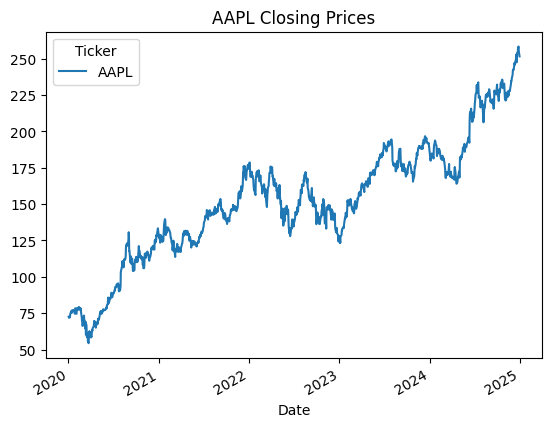

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download stock data (e.g., Apple)
ticker = "AAPL"
df = yf.download(ticker, start="2020-01-01", end="2024-12-31")

print(df.tail())
df['Close'].plot(title=f"{ticker} Closing Prices")
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Use only the 'Close' price
data = df[['Close']].values

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
X = []
y = []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=5, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 0.0923
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0023
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0010
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 9.8431e-04
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 9.4854e-04


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


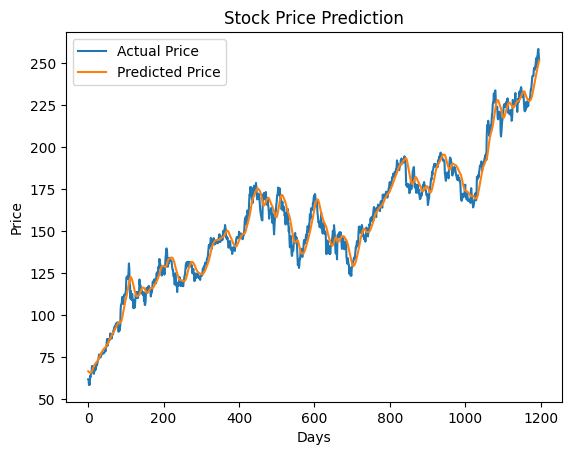

In [ ]:
predicted = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted)

# Plot actual vs predicted
plt.plot(data[60:], label="Actual Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.title("Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
!ngrok config add-authtoken "2x4HtiZdYZPZmSVtSBDDn4eyml8_v4nX8NdunK243VqTMA7Q"


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!ngrok config check

Valid configuration file at /root/.config/ngrok/ngrok.yml


In [ ]:
!cat ~/.config/ngrok/ngrok.yml


region: us
version: '2'
authtoken: YOUR_NGROK_AUTH_TOKEN_HERE


In [ ]:
!rm -rf /root/.config/ngrok


In [ ]:
!ngrok config add-authtoken  2x4HtiZdYZPZmSVtSBDDn4eyml8_v4nX8NdunK243VqTMA7Q


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [2]:
# STEP 1: Install required packages
!pip install streamlit yfinance keras scikit-learn pyngrok --quiet

# STEP 2: Add your ngrok auth token (required to host from Colab)
!ngrok config add-authtoken 2x4HtiZdYZPZmSVtSBDDn4eyml8_v4nX8NdunK243VqTMA7Q

  # Replace with your token

# STEP 3: Save the upgraded multi-day prediction UI as app.py
with open("app.py", "w") as f:
    f.write('''
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

st.set_page_config(page_title="📈 AI Stock Forecast", layout="centered")
st.title("📊 Multi-Day AI Stock Forecast")

ticker = st.text_input("Enter Stock Ticker (e.g., AAPL, INFY.NS)", "AAPL")
future_date = st.date_input("📅 Select date to predict until", min_value=datetime.today() + timedelta(days=1))

predict_btn = st.button("Predict")

if predict_btn and ticker:
    try:
        df = yf.download(ticker, period="150d")
        if df.empty or 'Close' not in df.columns:
            st.error("Stock data not available.")
        else:
            st.subheader(f"📈 Recent Prices for {ticker}")
            st.line_chart(df['Close'])

            # Preprocess data
            close_prices = df[['Close']].values
            scaler = MinMaxScaler()
            scaled_data = scaler.fit_transform(close_prices)

            # Create training dataset
            X_train, y_train = [], []
            for i in range(60, len(scaled_data)):
                X_train.append(scaled_data[i-60:i, 0])
                y_train.append(scaled_data[i, 0])
            X_train, y_train = np.array(X_train), np.array(y_train)
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

            # Build model
            model = Sequential()
            model.add(LSTM(50, return_sequences=False, input_shape=(60, 1)))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mean_squared_error')
            model.fit(X_train, y_train, epochs=10, batch_size=8, verbose=0)

            # Multi-day prediction
            today = datetime.today().date()
            n_days = (future_date - today).days

            last_60 = scaled_data[-60:]
            future_preds = []
            input_seq = last_60.reshape(1, 60, 1)

            for _ in range(n_days):
                next_pred_scaled = model.predict(input_seq, verbose=0)
                future_preds.append(next_pred_scaled[0][0])
                # Update input sequence
                next_seq = np.append(input_seq[0, 1:, 0], next_pred_scaled[0][0])
                input_seq = next_seq.reshape(1, 60, 1)

            predicted_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

            # Prepare DataFrame
            future_dates = [today + timedelta(days=i+1) for i in range(n_days)]
            result_df = pd.DataFrame({
                "Date": future_dates,
                "Predicted Close Price": predicted_prices
            })

            st.subheader("🔮 Forecasted Prices")
            st.dataframe(result_df.set_index("Date").style.format({"Predicted Close Price": "{:.2f}"}))
            st.line_chart(result_df.set_index("Date"))

    except Exception as e:
        st.error(f"Error: {e}")
''')

# STEP 4: Launch Streamlit app using ngrok
import time, threading
from pyngrok import ngrok

def run():
    !streamlit run app.py --server.headless true --server.enableCORS false > /dev/null 2>&1
threading.Thread(target=run).start()
time.sleep(5)

url = ngrok.connect(8501)
print(f"🔗 Open your AI Stock App: {url}")


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🔗 Open your AI Stock App: NgrokTunnel: "https://1cfb-35-231-217-187.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!kill $(lsof -t -i:4040)


In [ ]:

from pyngrok import ngrok

# Set the correct ngrok token manually
ngrok.set_auth_token("2x4HtiZdYZPZmSVtSBDDn4eyml8_v4nX8NdunK243VqTMA7Q")


In [1]:
import yfinance as yf

ticker = "AAPL"  # Or any other stock symbol
df = yf.download(ticker, period="150d")
df.to_csv("stock_data.csv")  # This saves the dataset locally


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:

!ngrok authtoken 2x4HtiZdYZPZmSVtSBDDn4eyml8_v4nX8NdunK243VqTMA7Q


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!cat ~/.config/ngrok/ngrok.yml


region: us
version: '2'
authtoken: YOUR_NGROK_AUTH_TOKEN_HERE


In [ ]:
from pyngrok import ngrok

# Authenticate with your token
ngrok.set_auth_token("2x4HtiZdYZPZmSVtSBDDn4eyml8_v4nX8NdunK243VqTMA7Q")

# Connect to port 8501 (Streamlit default)
public_url = ngrok.connect(8501)
print("🔗 Streamlit app URL:", public_url)




🔗 Streamlit app URL: NgrokTunnel: "https://1d91-35-231-217-187.ngrok-free.app" -> "http://localhost:8501"
